In [1]:
!pip install -U -q segmentation-models --user

from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import matplotlib.pyplot as plt 
import tensorflow_io as tfio
import tensorflow as tf


exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

Segmentation Models: using `tf.keras` framework.


# **IDRID OD Segmentation**

In [2]:
input_data = os.path.join('/kaggle/input/indian-diabetic-retinopathy-image-dataset/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set')
images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


target_data = os.path.join('/kaggle/input/indian-diabetic-retinopathy-image-dataset/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/5. Optic Disc')
masks = sorted(
    [
        os.path.join(target_data, fname)
        for fname in os.listdir(target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


In [11]:
IMAGE_SIZE = 256
BATCH_SIZE = 8

def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tfio.experimental.image.decode_tiff(image)
        image = image[..., 0] # (None, h, w)
        image = image[..., None] # (None, h, w, 1)
        image = tf.divide(image, 128)
        image = tf.image.resize(images=image[...,0][..., None], size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.int32)
    else:
        image = tf.io.decode_jpeg(image) # out: (h, w, 3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.
    return image

def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask  = read_files(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset

train_dataset = data_generator(images, masks)
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

In [12]:
from tensorflow import keras 

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
BACKBONE   = 'efficientnetb3'
n_classes  = 1 
activation = 'sigmoid' 
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights= None)
model.load_weights('/kaggle/input/efficientnetb3-weights/efficientnetb3_notop.h5', by_name= True)
#model.summary(line_length=110)

In [13]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=5):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/200
7/7 [==============================] - 24s 1s/step - loss: 0.5165 - accuracy: 0.7746
Epoch 2/200
7/7 [==============================] - 4s 512ms/step - loss: 0.4484 - accuracy: 0.8587
Epoch 3/200
7/7 [==============================] - 4s 522ms/step - loss: 0.4008 - accuracy: 0.9044
Epoch 4/200
7/7 [==============================] - 4s 514ms/step - loss: 0.3592 - accuracy: 0.9420
Epoch 5/200
7/7 [==============================] - 4s 514ms/step - loss: 0.3257 - accuracy: 0.9664
Epoch 6/200
7/7 [==============================] - 4s 508ms/step - loss: 0.2958 - accuracy: 0.9802


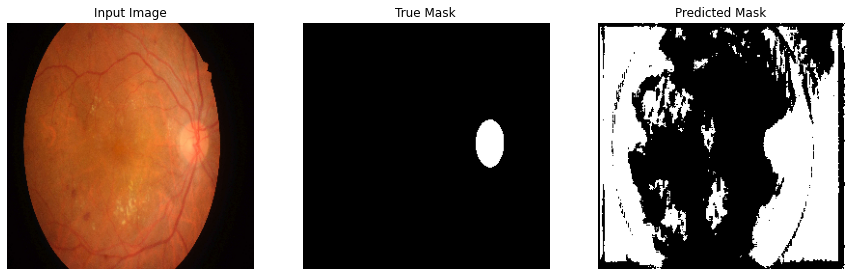


Sample Prediction after epoch 6

Epoch 7/200
7/7 [==============================] - 4s 496ms/step - loss: 0.2710 - accuracy: 0.9870
Epoch 8/200
7/7 [==============================] - 4s 519ms/step - loss: 0.2503 - accuracy: 0.9916
Epoch 9/200
7/7 [==============================] - 4s 521ms/step - loss: 0.2317 - accuracy: 0.9945
Epoch 10/200
7/7 [==============================] - 4s 512ms/step - loss: 0.2163 - accuracy: 0.9961
Epoch 11/200
7/7 [==============================] - 4s 520ms/step - loss: 0.2030 - accuracy: 0.9968


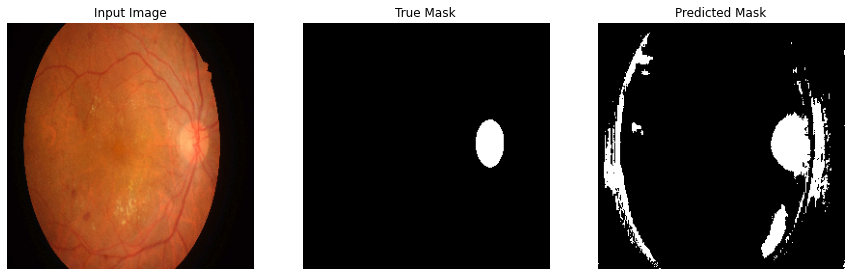


Sample Prediction after epoch 11

Epoch 12/200
7/7 [==============================] - 4s 507ms/step - loss: 0.1909 - accuracy: 0.9973
Epoch 13/200
7/7 [==============================] - 4s 518ms/step - loss: 0.1807 - accuracy: 0.9976
Epoch 14/200
7/7 [==============================] - 4s 524ms/step - loss: 0.1718 - accuracy: 0.9980
Epoch 15/200
7/7 [==============================] - 4s 517ms/step - loss: 0.1636 - accuracy: 0.9982
Epoch 16/200
7/7 [==============================] - 4s 525ms/step - loss: 0.1563 - accuracy: 0.9982


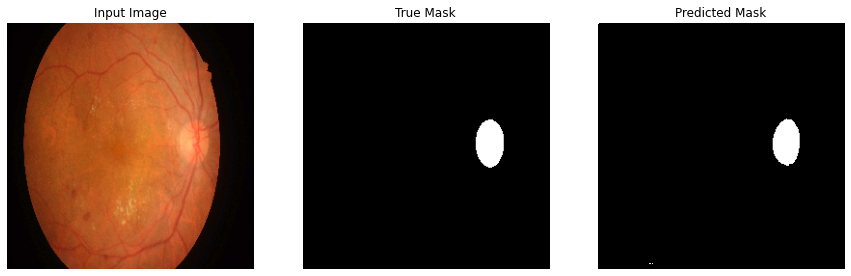


Sample Prediction after epoch 16

Epoch 17/200
7/7 [==============================] - 4s 518ms/step - loss: 0.1496 - accuracy: 0.9985
Epoch 18/200
7/7 [==============================] - 4s 534ms/step - loss: 0.1435 - accuracy: 0.9985
Epoch 19/200
7/7 [==============================] - 4s 520ms/step - loss: 0.1380 - accuracy: 0.9986
Epoch 20/200
7/7 [==============================] - 4s 528ms/step - loss: 0.1328 - accuracy: 0.9986
Epoch 21/200
7/7 [==============================] - 4s 516ms/step - loss: 0.1282 - accuracy: 0.9986


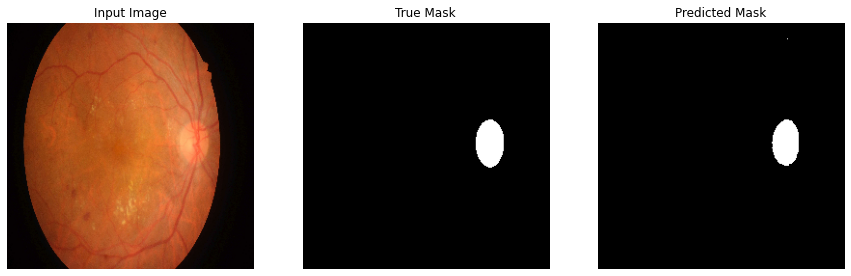


Sample Prediction after epoch 21

Epoch 22/200
7/7 [==============================] - 4s 530ms/step - loss: 0.1239 - accuracy: 0.9988
Epoch 23/200
7/7 [==============================] - 4s 505ms/step - loss: 0.1196 - accuracy: 0.9988
Epoch 24/200
7/7 [==============================] - 4s 503ms/step - loss: 0.1159 - accuracy: 0.9988
Epoch 25/200
7/7 [==============================] - 4s 509ms/step - loss: 0.1123 - accuracy: 0.9988
Epoch 26/200
7/7 [==============================] - 4s 516ms/step - loss: 0.1091 - accuracy: 0.9988


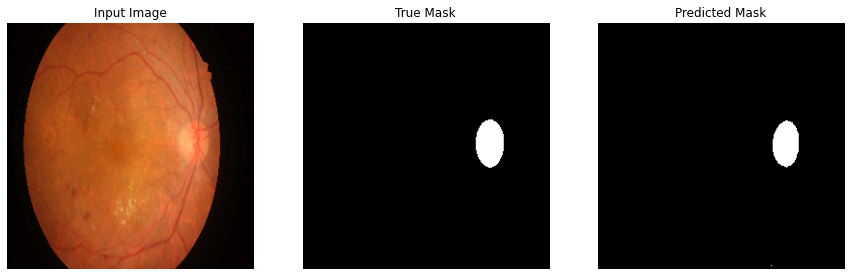


Sample Prediction after epoch 26

Epoch 27/200
7/7 [==============================] - 4s 533ms/step - loss: 0.1059 - accuracy: 0.9989
Epoch 28/200
7/7 [==============================] - 4s 515ms/step - loss: 0.1029 - accuracy: 0.9988
Epoch 29/200
7/7 [==============================] - 4s 512ms/step - loss: 0.1000 - accuracy: 0.9990
Epoch 30/200
7/7 [==============================] - 4s 516ms/step - loss: 0.0971 - accuracy: 0.9991
Epoch 31/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0944 - accuracy: 0.9990


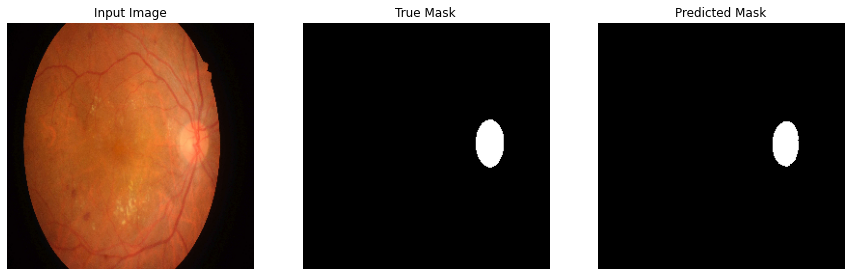


Sample Prediction after epoch 31

Epoch 32/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0920 - accuracy: 0.9991
Epoch 33/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0897 - accuracy: 0.9990
Epoch 34/200
7/7 [==============================] - 4s 516ms/step - loss: 0.0874 - accuracy: 0.9989
Epoch 35/200
7/7 [==============================] - 4s 533ms/step - loss: 0.0856 - accuracy: 0.9987
Epoch 36/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0833 - accuracy: 0.9987


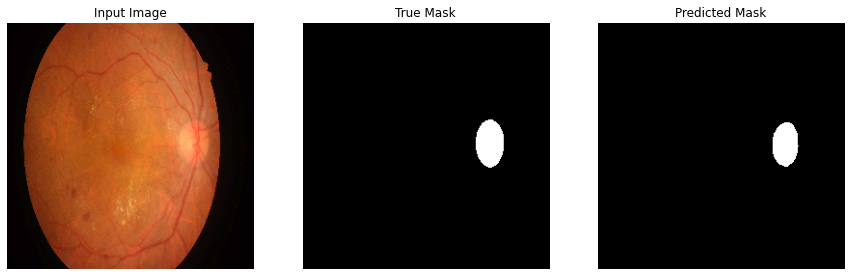


Sample Prediction after epoch 36

Epoch 37/200
7/7 [==============================] - 4s 518ms/step - loss: 0.0813 - accuracy: 0.9987
Epoch 38/200
7/7 [==============================] - 4s 532ms/step - loss: 0.0790 - accuracy: 0.9989
Epoch 39/200
7/7 [==============================] - 4s 525ms/step - loss: 0.0769 - accuracy: 0.9991
Epoch 40/200
7/7 [==============================] - 4s 530ms/step - loss: 0.0748 - accuracy: 0.9992
Epoch 41/200
7/7 [==============================] - 4s 537ms/step - loss: 0.0730 - accuracy: 0.9992


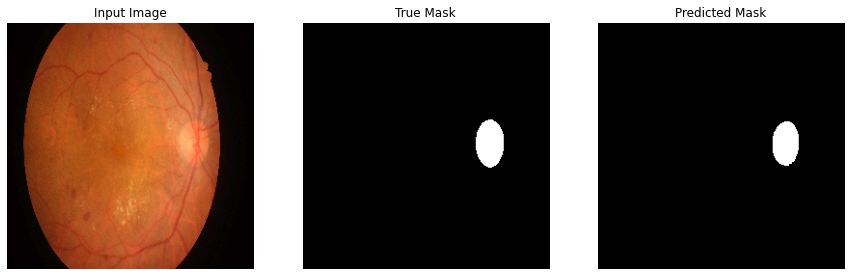


Sample Prediction after epoch 41

Epoch 42/200
7/7 [==============================] - 4s 517ms/step - loss: 0.0712 - accuracy: 0.9993
Epoch 43/200
7/7 [==============================] - 4s 518ms/step - loss: 0.0696 - accuracy: 0.9993
Epoch 44/200
7/7 [==============================] - 4s 525ms/step - loss: 0.0680 - accuracy: 0.9993
Epoch 45/200
7/7 [==============================] - 4s 514ms/step - loss: 0.0665 - accuracy: 0.9993
Epoch 46/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0649 - accuracy: 0.9993


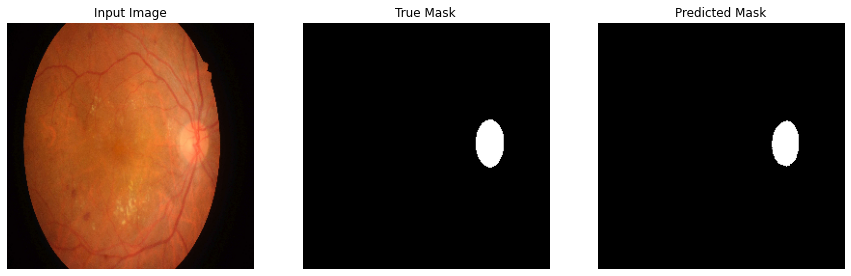


Sample Prediction after epoch 46

Epoch 47/200
7/7 [==============================] - 4s 529ms/step - loss: 0.0635 - accuracy: 0.9993
Epoch 48/200
7/7 [==============================] - 4s 507ms/step - loss: 0.0622 - accuracy: 0.9992
Epoch 49/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0608 - accuracy: 0.9992
Epoch 50/200
7/7 [==============================] - 4s 502ms/step - loss: 0.0596 - accuracy: 0.9992
Epoch 51/200
7/7 [==============================] - 4s 522ms/step - loss: 0.0582 - accuracy: 0.9992


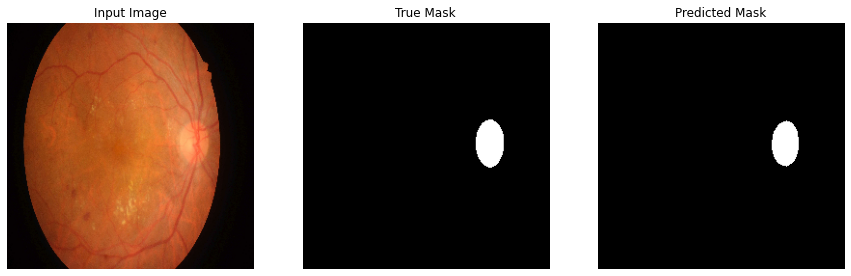


Sample Prediction after epoch 51

Epoch 52/200
7/7 [==============================] - 4s 510ms/step - loss: 0.0570 - accuracy: 0.9992
Epoch 53/200
7/7 [==============================] - 4s 525ms/step - loss: 0.0558 - accuracy: 0.9993
Epoch 54/200
7/7 [==============================] - 4s 542ms/step - loss: 0.0547 - accuracy: 0.9992
Epoch 55/200
7/7 [==============================] - 4s 504ms/step - loss: 0.0535 - accuracy: 0.9992
Epoch 56/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0524 - accuracy: 0.9993


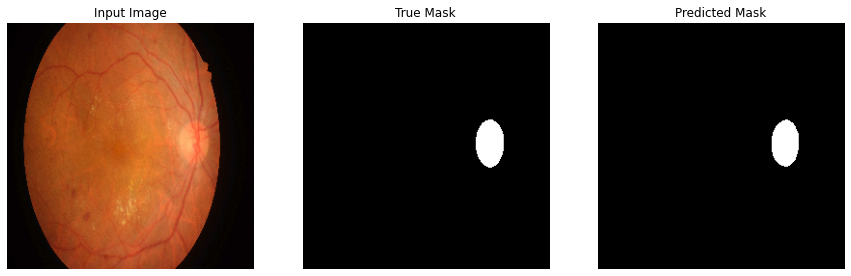


Sample Prediction after epoch 56

Epoch 57/200
7/7 [==============================] - 4s 505ms/step - loss: 0.0514 - accuracy: 0.9993
Epoch 58/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0504 - accuracy: 0.9993
Epoch 59/200
7/7 [==============================] - 4s 524ms/step - loss: 0.0493 - accuracy: 0.9994
Epoch 60/200
7/7 [==============================] - 4s 527ms/step - loss: 0.0482 - accuracy: 0.9994
Epoch 61/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0473 - accuracy: 0.9995


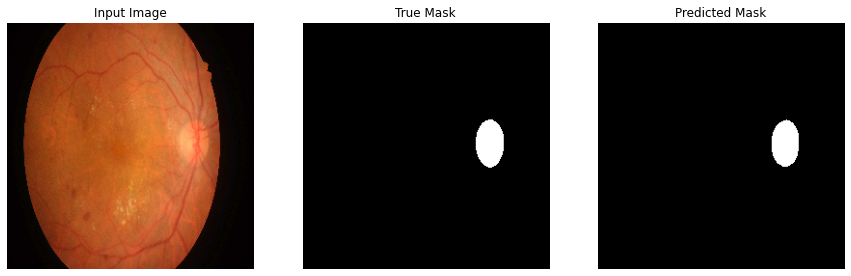


Sample Prediction after epoch 61

Epoch 62/200
7/7 [==============================] - 4s 499ms/step - loss: 0.0464 - accuracy: 0.9995
Epoch 63/200
7/7 [==============================] - 4s 514ms/step - loss: 0.0455 - accuracy: 0.9994
Epoch 64/200
7/7 [==============================] - 4s 503ms/step - loss: 0.0447 - accuracy: 0.9993
Epoch 65/200
7/7 [==============================] - 4s 526ms/step - loss: 0.0439 - accuracy: 0.9993
Epoch 66/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0431 - accuracy: 0.9993


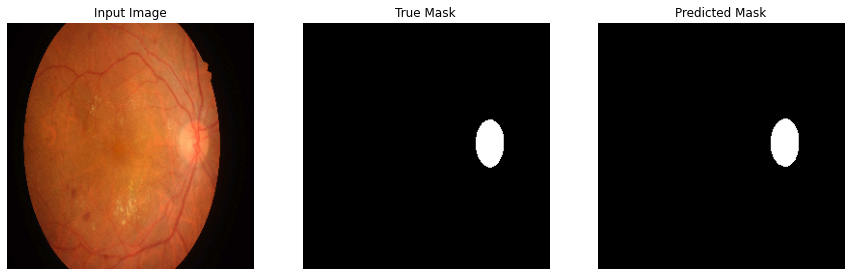


Sample Prediction after epoch 66

Epoch 67/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0424 - accuracy: 0.9992
Epoch 68/200
7/7 [==============================] - 4s 521ms/step - loss: 0.0417 - accuracy: 0.9991
Epoch 69/200
7/7 [==============================] - 4s 524ms/step - loss: 0.0410 - accuracy: 0.9991
Epoch 70/200
7/7 [==============================] - 4s 511ms/step - loss: 0.0401 - accuracy: 0.9993
Epoch 71/200
7/7 [==============================] - 4s 520ms/step - loss: 0.0393 - accuracy: 0.9993


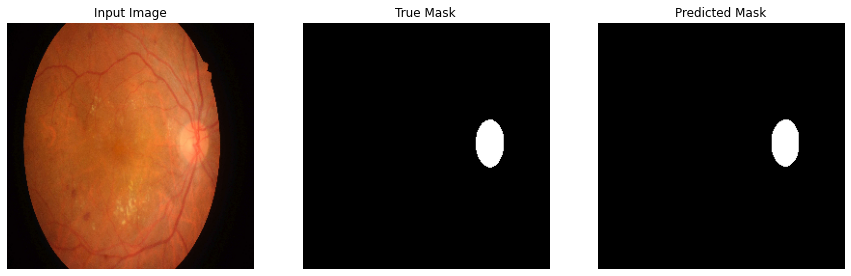


Sample Prediction after epoch 71

Epoch 72/200
7/7 [==============================] - 4s 512ms/step - loss: 0.0386 - accuracy: 0.9994
Epoch 73/200
7/7 [==============================] - 4s 528ms/step - loss: 0.0379 - accuracy: 0.9995
Epoch 74/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0372 - accuracy: 0.9994
Epoch 75/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0366 - accuracy: 0.9994
Epoch 76/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0360 - accuracy: 0.9994


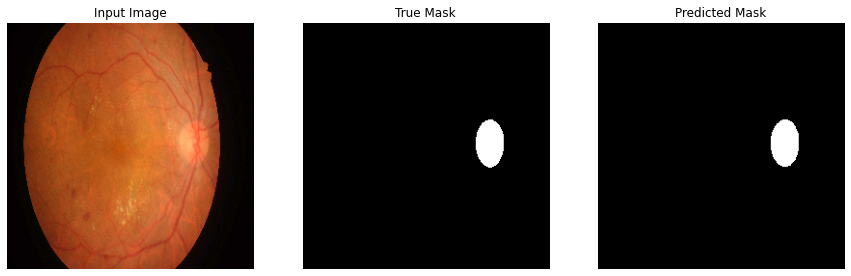


Sample Prediction after epoch 76

Epoch 77/200
7/7 [==============================] - 4s 496ms/step - loss: 0.0354 - accuracy: 0.9994
Epoch 78/200
7/7 [==============================] - 4s 509ms/step - loss: 0.0348 - accuracy: 0.9994
Epoch 79/200
7/7 [==============================] - 4s 521ms/step - loss: 0.0342 - accuracy: 0.9994
Epoch 80/200
7/7 [==============================] - 4s 517ms/step - loss: 0.0336 - accuracy: 0.9994
Epoch 81/200
7/7 [==============================] - 4s 554ms/step - loss: 0.0330 - accuracy: 0.9994


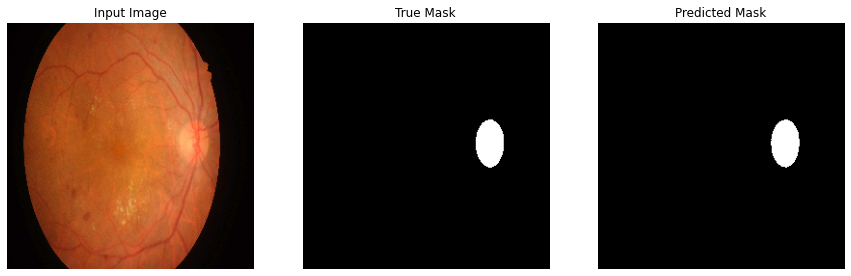


Sample Prediction after epoch 81

Epoch 82/200
7/7 [==============================] - 4s 510ms/step - loss: 0.0326 - accuracy: 0.9994
Epoch 83/200
7/7 [==============================] - 4s 522ms/step - loss: 0.0321 - accuracy: 0.9993
Epoch 84/200
7/7 [==============================] - 4s 524ms/step - loss: 0.0314 - accuracy: 0.9994
Epoch 85/200
7/7 [==============================] - 4s 530ms/step - loss: 0.0310 - accuracy: 0.9994
Epoch 86/200
7/7 [==============================] - 4s 503ms/step - loss: 0.0304 - accuracy: 0.9995


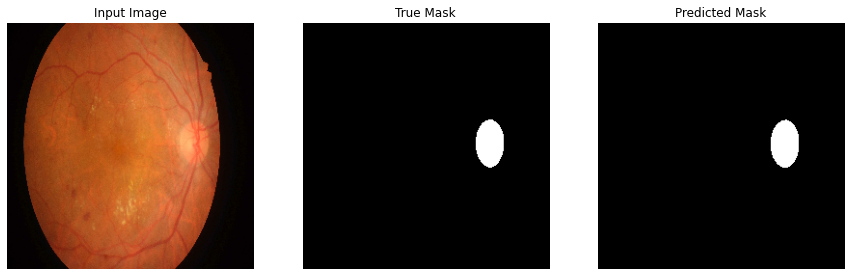


Sample Prediction after epoch 86

Epoch 87/200
7/7 [==============================] - 4s 506ms/step - loss: 0.0299 - accuracy: 0.9995
Epoch 88/200
7/7 [==============================] - 4s 521ms/step - loss: 0.0294 - accuracy: 0.9995
Epoch 89/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0289 - accuracy: 0.9995
Epoch 90/200
7/7 [==============================] - 4s 514ms/step - loss: 0.0285 - accuracy: 0.9995
Epoch 91/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0280 - accuracy: 0.9995


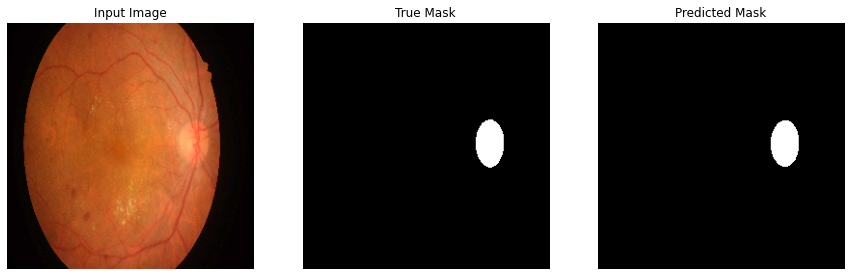


Sample Prediction after epoch 91

Epoch 92/200
7/7 [==============================] - 4s 508ms/step - loss: 0.0277 - accuracy: 0.9994
Epoch 93/200
7/7 [==============================] - 4s 503ms/step - loss: 0.0273 - accuracy: 0.9994
Epoch 94/200
7/7 [==============================] - 4s 520ms/step - loss: 0.0269 - accuracy: 0.9994
Epoch 95/200
7/7 [==============================] - 4s 538ms/step - loss: 0.0264 - accuracy: 0.9995
Epoch 96/200
7/7 [==============================] - 4s 506ms/step - loss: 0.0259 - accuracy: 0.9995


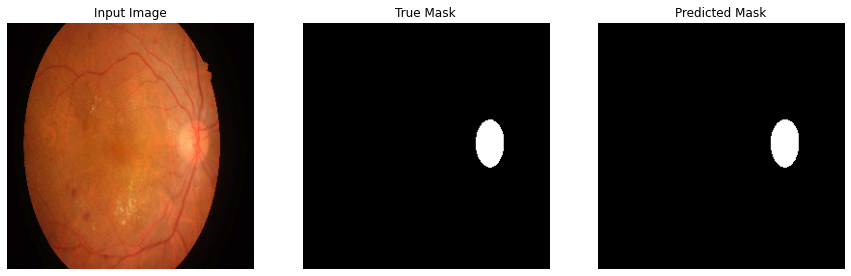


Sample Prediction after epoch 96

Epoch 97/200
7/7 [==============================] - 4s 526ms/step - loss: 0.0255 - accuracy: 0.9995
Epoch 98/200
7/7 [==============================] - 4s 511ms/step - loss: 0.0250 - accuracy: 0.9996
Epoch 99/200
7/7 [==============================] - 4s 512ms/step - loss: 0.0247 - accuracy: 0.9996
Epoch 100/200
7/7 [==============================] - 4s 516ms/step - loss: 0.0243 - accuracy: 0.9996
Epoch 101/200
7/7 [==============================] - 4s 509ms/step - loss: 0.0240 - accuracy: 0.9995


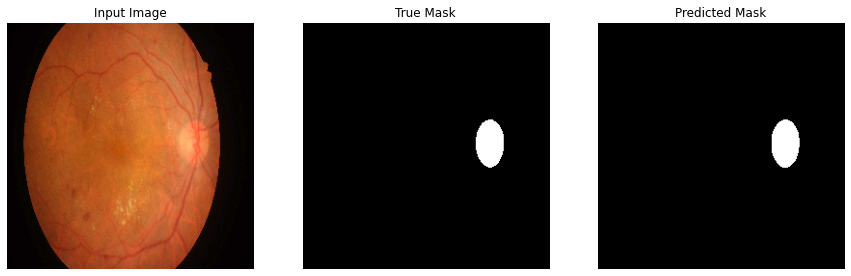


Sample Prediction after epoch 101

Epoch 102/200
7/7 [==============================] - 4s 507ms/step - loss: 0.0236 - accuracy: 0.9995
Epoch 103/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0233 - accuracy: 0.9995
Epoch 104/200
7/7 [==============================] - 4s 527ms/step - loss: 0.0230 - accuracy: 0.9994
Epoch 105/200
7/7 [==============================] - 4s 511ms/step - loss: 0.0227 - accuracy: 0.9994
Epoch 106/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0224 - accuracy: 0.9994


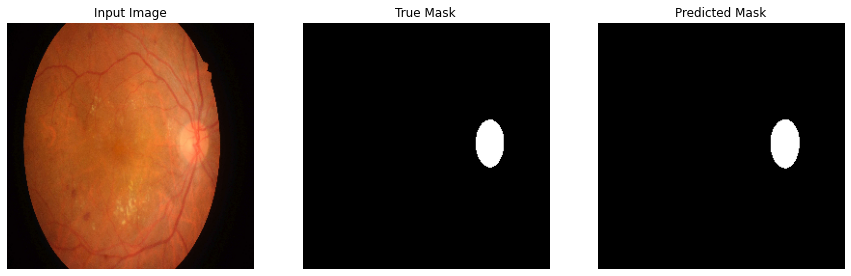


Sample Prediction after epoch 106

Epoch 107/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0220 - accuracy: 0.9995
Epoch 108/200
7/7 [==============================] - 4s 517ms/step - loss: 0.0216 - accuracy: 0.9995
Epoch 109/200
7/7 [==============================] - 4s 516ms/step - loss: 0.0212 - accuracy: 0.9996
Epoch 110/200
7/7 [==============================] - 4s 521ms/step - loss: 0.0209 - accuracy: 0.9996
Epoch 111/200
7/7 [==============================] - 4s 526ms/step - loss: 0.0206 - accuracy: 0.9996


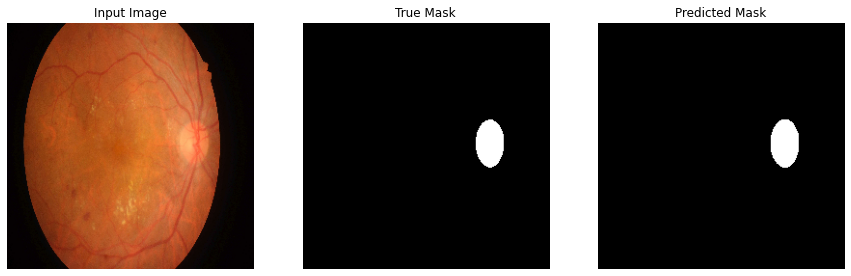


Sample Prediction after epoch 111

Epoch 112/200
7/7 [==============================] - 4s 514ms/step - loss: 0.0204 - accuracy: 0.9995
Epoch 113/200
7/7 [==============================] - 4s 527ms/step - loss: 0.0202 - accuracy: 0.9996
Epoch 114/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0200 - accuracy: 0.9995
Epoch 115/200
7/7 [==============================] - 4s 518ms/step - loss: 0.0197 - accuracy: 0.9995
Epoch 116/200
7/7 [==============================] - 4s 504ms/step - loss: 0.0196 - accuracy: 0.9993


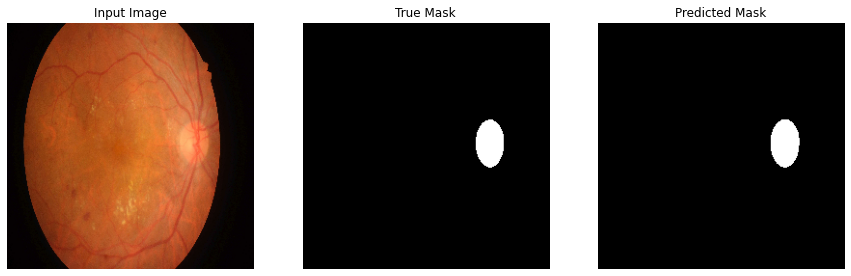


Sample Prediction after epoch 116

Epoch 117/200
7/7 [==============================] - 4s 490ms/step - loss: 0.0192 - accuracy: 0.9995
Epoch 118/200
7/7 [==============================] - 4s 516ms/step - loss: 0.0190 - accuracy: 0.9995
Epoch 119/200
7/7 [==============================] - 4s 520ms/step - loss: 0.0186 - accuracy: 0.9996
Epoch 120/200
7/7 [==============================] - 4s 520ms/step - loss: 0.0184 - accuracy: 0.9995
Epoch 121/200
7/7 [==============================] - 4s 521ms/step - loss: 0.0182 - accuracy: 0.9995


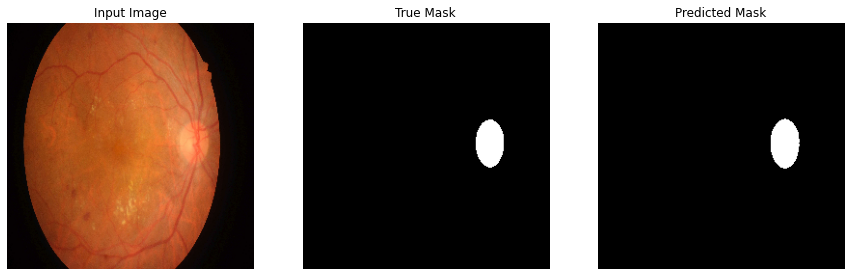


Sample Prediction after epoch 121

Epoch 122/200
7/7 [==============================] - 4s 512ms/step - loss: 0.0179 - accuracy: 0.9995
Epoch 123/200
7/7 [==============================] - 4s 516ms/step - loss: 0.0177 - accuracy: 0.9995
Epoch 124/200
7/7 [==============================] - 4s 522ms/step - loss: 0.0175 - accuracy: 0.9995
Epoch 125/200
7/7 [==============================] - 4s 524ms/step - loss: 0.0172 - accuracy: 0.9996
Epoch 126/200
7/7 [==============================] - 4s 509ms/step - loss: 0.0170 - accuracy: 0.9996


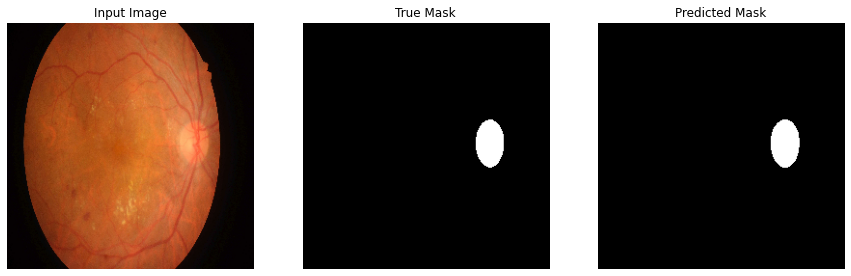


Sample Prediction after epoch 126

Epoch 127/200
7/7 [==============================] - 4s 505ms/step - loss: 0.0167 - accuracy: 0.9996
Epoch 128/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0166 - accuracy: 0.9996
Epoch 129/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0163 - accuracy: 0.9996
Epoch 130/200
7/7 [==============================] - 4s 520ms/step - loss: 0.0161 - accuracy: 0.9996
Epoch 131/200
7/7 [==============================] - 4s 518ms/step - loss: 0.0160 - accuracy: 0.9996


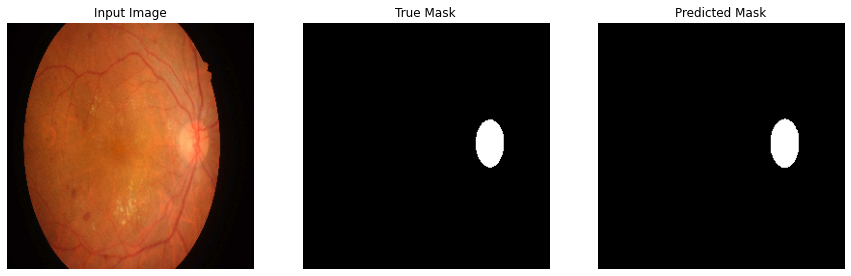


Sample Prediction after epoch 131

Epoch 132/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0158 - accuracy: 0.9996
Epoch 133/200
7/7 [==============================] - 4s 526ms/step - loss: 0.0157 - accuracy: 0.9995
Epoch 134/200
7/7 [==============================] - 4s 521ms/step - loss: 0.0155 - accuracy: 0.9995
Epoch 135/200
7/7 [==============================] - 4s 525ms/step - loss: 0.0152 - accuracy: 0.9996
Epoch 136/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0151 - accuracy: 0.9996


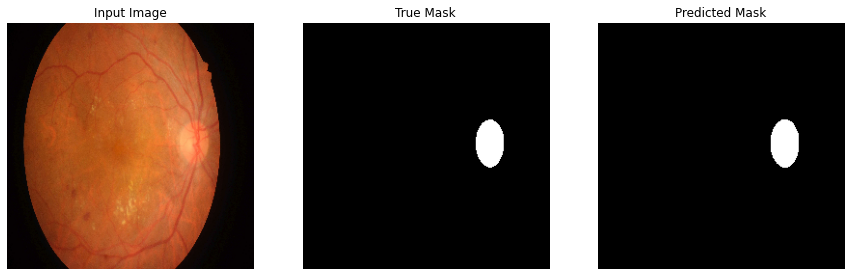


Sample Prediction after epoch 136

Epoch 137/200
7/7 [==============================] - 4s 493ms/step - loss: 0.0148 - accuracy: 0.9996
Epoch 138/200
7/7 [==============================] - 4s 508ms/step - loss: 0.0148 - accuracy: 0.9996
Epoch 139/200
7/7 [==============================] - 4s 520ms/step - loss: 0.0145 - accuracy: 0.9996
Epoch 140/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0144 - accuracy: 0.9996
Epoch 141/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0142 - accuracy: 0.9996


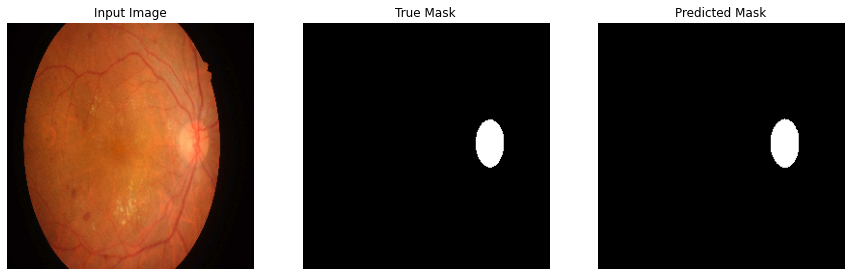


Sample Prediction after epoch 141

Epoch 142/200
7/7 [==============================] - 4s 514ms/step - loss: 0.0140 - accuracy: 0.9996
Epoch 143/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0139 - accuracy: 0.9996
Epoch 144/200
7/7 [==============================] - 4s 520ms/step - loss: 0.0137 - accuracy: 0.9996
Epoch 145/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0135 - accuracy: 0.9997
Epoch 146/200
7/7 [==============================] - 4s 516ms/step - loss: 0.0135 - accuracy: 0.9996


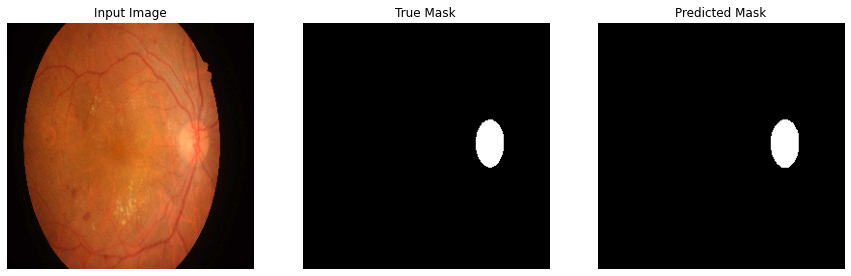


Sample Prediction after epoch 146

Epoch 147/200
7/7 [==============================] - 4s 511ms/step - loss: 0.0133 - accuracy: 0.9996
Epoch 148/200
7/7 [==============================] - 4s 538ms/step - loss: 0.0133 - accuracy: 0.9994
Epoch 149/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0131 - accuracy: 0.9995
Epoch 150/200
7/7 [==============================] - 4s 510ms/step - loss: 0.0130 - accuracy: 0.9995
Epoch 151/200
7/7 [==============================] - 4s 506ms/step - loss: 0.0127 - accuracy: 0.9996


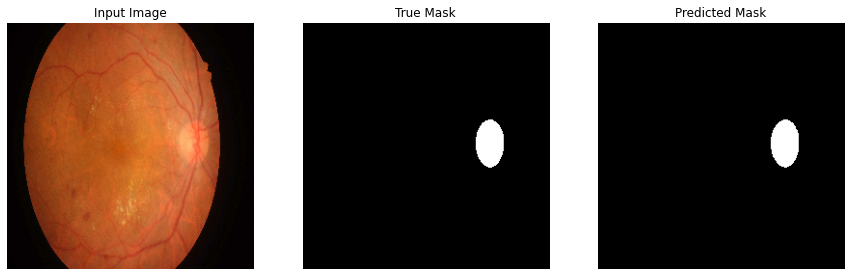


Sample Prediction after epoch 151

Epoch 152/200
7/7 [==============================] - 4s 504ms/step - loss: 0.0126 - accuracy: 0.9996
Epoch 153/200
7/7 [==============================] - 4s 510ms/step - loss: 0.0124 - accuracy: 0.9997
Epoch 154/200
7/7 [==============================] - 4s 501ms/step - loss: 0.0123 - accuracy: 0.9997
Epoch 155/200
7/7 [==============================] - 4s 527ms/step - loss: 0.0122 - accuracy: 0.9997
Epoch 156/200
7/7 [==============================] - 4s 530ms/step - loss: 0.0120 - accuracy: 0.9997


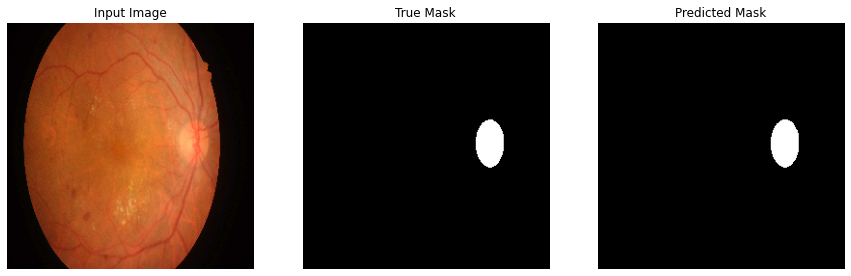


Sample Prediction after epoch 156

Epoch 157/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0119 - accuracy: 0.9996
Epoch 158/200
7/7 [==============================] - 4s 524ms/step - loss: 0.0119 - accuracy: 0.9996
Epoch 159/200
7/7 [==============================] - 4s 518ms/step - loss: 0.0117 - accuracy: 0.9996
Epoch 160/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0116 - accuracy: 0.9996
Epoch 161/200
7/7 [==============================] - 4s 522ms/step - loss: 0.0115 - accuracy: 0.9996


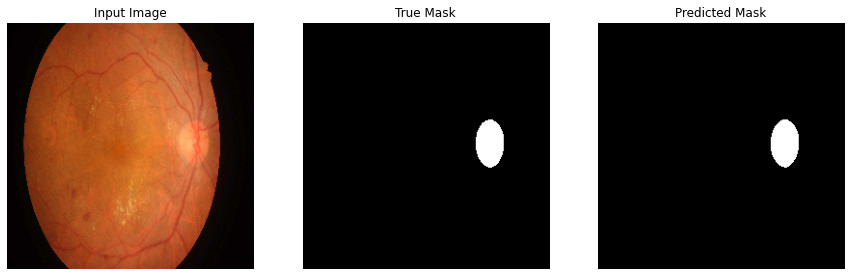


Sample Prediction after epoch 161

Epoch 162/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0114 - accuracy: 0.9996
Epoch 163/200
7/7 [==============================] - 4s 533ms/step - loss: 0.0112 - accuracy: 0.9996
Epoch 164/200
7/7 [==============================] - 4s 527ms/step - loss: 0.0111 - accuracy: 0.9997
Epoch 165/200
7/7 [==============================] - 4s 509ms/step - loss: 0.0110 - accuracy: 0.9997
Epoch 166/200
7/7 [==============================] - 4s 526ms/step - loss: 0.0109 - accuracy: 0.9997


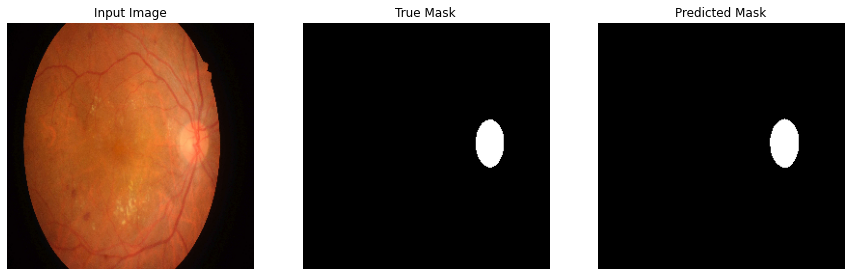


Sample Prediction after epoch 166

Epoch 167/200
7/7 [==============================] - 4s 500ms/step - loss: 0.0109 - accuracy: 0.9996
Epoch 168/200
7/7 [==============================] - 4s 511ms/step - loss: 0.0107 - accuracy: 0.9996
Epoch 169/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0107 - accuracy: 0.9996
Epoch 170/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0105 - accuracy: 0.9996
Epoch 171/200
7/7 [==============================] - 4s 495ms/step - loss: 0.0105 - accuracy: 0.9996


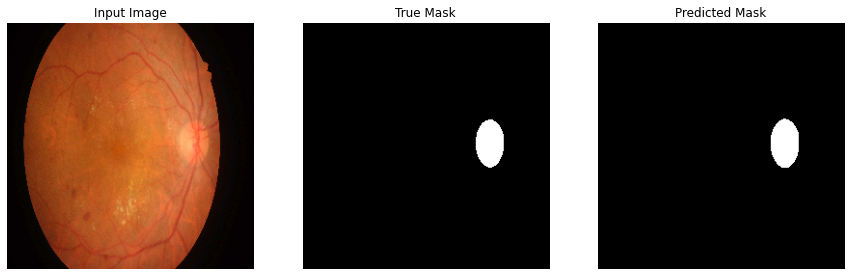


Sample Prediction after epoch 171

Epoch 172/200
7/7 [==============================] - 4s 504ms/step - loss: 0.0103 - accuracy: 0.9996
Epoch 173/200
7/7 [==============================] - 4s 499ms/step - loss: 0.0103 - accuracy: 0.9995
Epoch 174/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0102 - accuracy: 0.9996
Epoch 175/200
7/7 [==============================] - 4s 529ms/step - loss: 0.0101 - accuracy: 0.9996
Epoch 176/200
7/7 [==============================] - 4s 528ms/step - loss: 0.0100 - accuracy: 0.9996


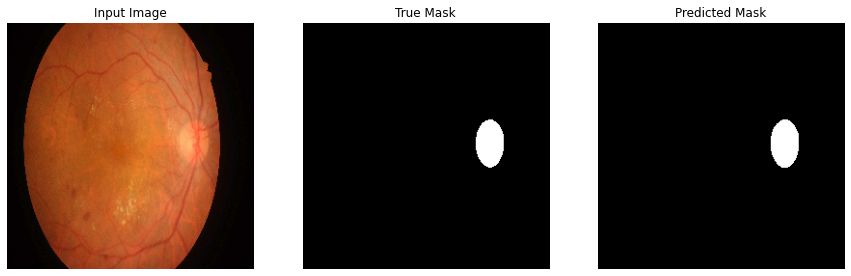


Sample Prediction after epoch 176

Epoch 177/200
7/7 [==============================] - 4s 532ms/step - loss: 0.0098 - accuracy: 0.9997
Epoch 178/200
7/7 [==============================] - 4s 522ms/step - loss: 0.0097 - accuracy: 0.9997
Epoch 179/200
7/7 [==============================] - 4s 531ms/step - loss: 0.0095 - accuracy: 0.9998
Epoch 180/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0095 - accuracy: 0.9997
Epoch 181/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0094 - accuracy: 0.9998


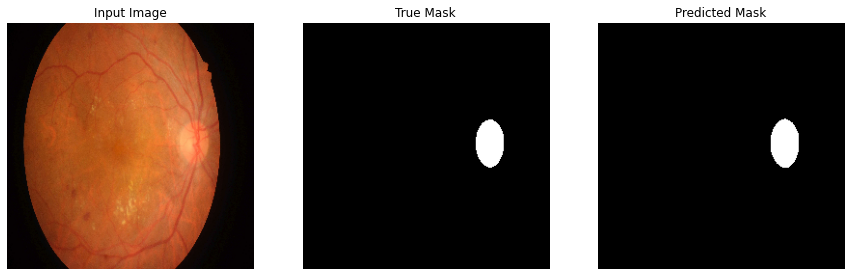


Sample Prediction after epoch 181

Epoch 182/200
7/7 [==============================] - 4s 522ms/step - loss: 0.0093 - accuracy: 0.9998
Epoch 183/200
7/7 [==============================] - 4s 515ms/step - loss: 0.0092 - accuracy: 0.9998
Epoch 184/200
7/7 [==============================] - 4s 520ms/step - loss: 0.0091 - accuracy: 0.9998
Epoch 185/200
7/7 [==============================] - 4s 524ms/step - loss: 0.0090 - accuracy: 0.9998
Epoch 186/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0090 - accuracy: 0.9997


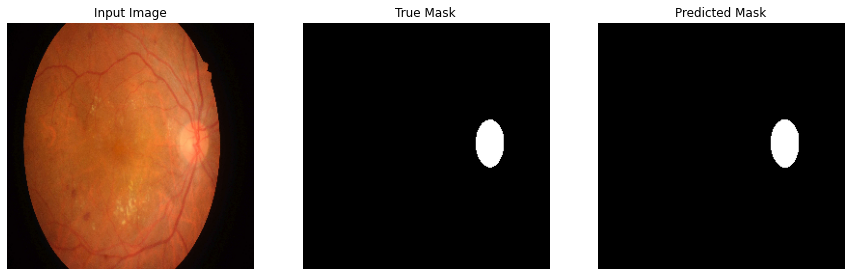


Sample Prediction after epoch 186

Epoch 187/200
7/7 [==============================] - 4s 523ms/step - loss: 0.0089 - accuracy: 0.9998
Epoch 188/200
7/7 [==============================] - 4s 503ms/step - loss: 0.0089 - accuracy: 0.9997
Epoch 189/200
7/7 [==============================] - 4s 522ms/step - loss: 0.0088 - accuracy: 0.9997
Epoch 190/200
7/7 [==============================] - 4s 524ms/step - loss: 0.0088 - accuracy: 0.9996
Epoch 191/200
7/7 [==============================] - 4s 507ms/step - loss: 0.0087 - accuracy: 0.9996


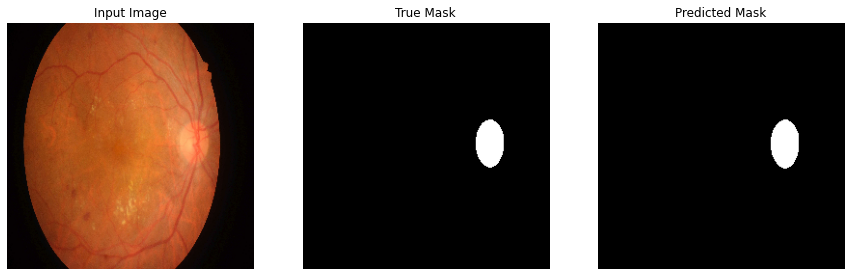


Sample Prediction after epoch 191

Epoch 192/200
7/7 [==============================] - 4s 519ms/step - loss: 0.0087 - accuracy: 0.9996
Epoch 193/200
7/7 [==============================] - 4s 506ms/step - loss: 0.0087 - accuracy: 0.9995
Epoch 194/200
7/7 [==============================] - 4s 533ms/step - loss: 0.0087 - accuracy: 0.9995
Epoch 195/200
7/7 [==============================] - 4s 513ms/step - loss: 0.0085 - accuracy: 0.9996
Epoch 196/200
7/7 [==============================] - 4s 532ms/step - loss: 0.0084 - accuracy: 0.9996


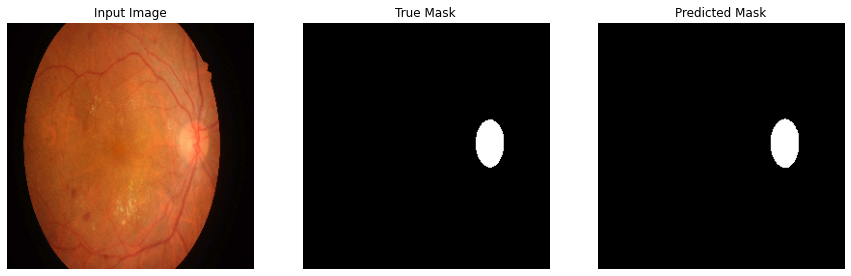


Sample Prediction after epoch 196

Epoch 197/200
7/7 [==============================] - 4s 510ms/step - loss: 0.0082 - accuracy: 0.9997
Epoch 198/200
7/7 [==============================] - 4s 514ms/step - loss: 0.0081 - accuracy: 0.9997
Epoch 199/200
7/7 [==============================] - 4s 518ms/step - loss: 0.0081 - accuracy: 0.9997
Epoch 200/200
7/7 [==============================] - 4s 512ms/step - loss: 0.0080 - accuracy: 0.9997


In [14]:
# define optomizer
optim = keras.optimizers.Adam(0.0001)
bce   = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics)

model.fit(
    train_dataset, 
    callbacks=[DisplayCallback(train_dataset)],
    epochs=200
)

In [15]:
def preprocess_image(image_path, image_size=256):
    """Load and preprocess a single image for prediction."""
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    image = image / 255.0  # normalize
    image = tf.expand_dims(image, axis=0)  # add batch dimension
    return image


In [24]:
test_image_path = '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/10003_left.jpeg'
image = preprocess_image(test_image_path, IMAGE_SIZE)

pred_mask = model.predict(image)
pred_mask = (pred_mask > 0.5).astype("int32")  # threshold to get binary mask


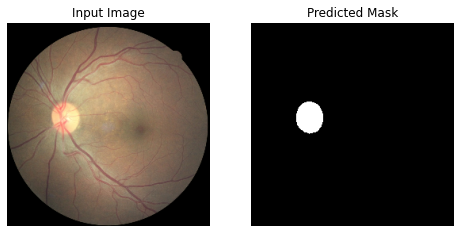

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# Input image
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(tf.squeeze(image))  # remove batch dimension
plt.axis("off")

# Predicted mask
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(tf.squeeze(pred_mask), cmap="gray")  # remove batch dimension
plt.axis("off")

plt.show()


In [26]:
model.save('efficientnetb3_unet_idrid.h5')


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
